In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# System:
import os
import re
import csv
import gzip
import time
import datetime
import sys
import gc
import six.moves.cPickle as pickle
from tqdm import tqdm, tqdm_notebook
from IPython import get_ipython
ipython_shell = get_ipython()

# Math 
import scipy.stats as st
import numpy as np
from scipy.cluster import hierarchy as sch

# Plotting:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec, ticker, markers
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from IPython import display
from polo import optimal_leaf_ordering
from scipy import sparse

# Local paths and functions:
import auxfunc_masterlist as AUX
import parse_config

# For random data:
rng = np.random

# For plot points
from scipy.sparse import coo_matrix, csr_matrix
import pandas as pd, numpy as np
from collections import OrderedDict as odict

# Style
sns.set(style="ticks", color_codes=True)

ModuleNotFoundError: No module named 'matplotlib'

# Statistics of ML intersections

#### Statistics on occupancy, intersection with the masterlist:
1. Number of locations labeled Enhancer, Promoter, or Both 
2. Distributions 
    - How many enh/prom per epigenome (XXX +/- YYY)
    - How many epigenome per enh/prom
3. Saturation curve (rarefaction)
    - Starting with the matched roadmap samples
    - Overall 
    - Which epigenomes have the larges # of "uncommon elements" - aka - potentially need more study 
4. How much redundancy in the masterlist?

In [27]:
# Load in data  and collapse matrix:
ecpref = '/home/cboix' + os.environ['DBDIR'] + '/observed_aux_18_on_mixed_impobs_QCUT_ENH_bin_on_mixed_impobs_r200_e0_allchr_merged'
pcpref = '/home/cboix' + os.environ['DBDIR'] + '/observed_aux_18_on_mixed_impobs_QCUT_PROM_bin_on_mixed_impobs_r200_e0_allchr_merged'
hpref = '/home/cboix' + os.environ['DBDIR'] + '/H3K27ac_all_bin_on_mixed_impobs_r25_e100_allchr_merged'

In [28]:
def get_data(pref):
    with gzip.open(pref + "_csr.cp.gz", 'rb') as f:
        X = pickle.load(f, encoding='latin1')
    return(X)

def get_names(pref):
    with gzip.open(pref + "_attr.cp.gz", 'rb') as f:
        attr = pickle.load(f, encoding='latin1')
    return(attr['names'])

# Load data:
eX = get_data(ecpref)
pX = get_data(pcpref)
hX = get_data(hpref)

# Load all names:
enam = get_names(ecpref)
pnam = get_names(pcpref)
hnam = get_names(hpref)
hnam = [re.sub(".*BSS","BSS", n).split("_")[0] for n in hnam]

In [31]:
# Reorder h matrix to match the other two:
hord = np.array([np.where(np.array(hnam) == n)[0][0] for n in enam])
hXord = hX[:, hord]
# Turn hX into binary matrix, thresholded at 2:
hXthresh = 1 * (hXord > 0)

In [32]:
# Merge matrices: (NOTE: Also do this with STRENGTH of matrices)
ehx = eX.multiply(hXthresh)
phx = pX.multiply(hXthresh)
# STATISTICS on % kept dhs:
print(pX.nnz, "to", phx.nnz, "is pct:", round(100 * phx.nnz/ pX.nnz, 2))
print(eX.nnz, "to", ehx.nnz, "is pct:", round(100 * ehx.nnz/ eX.nnz, 2))
 # STATISTICS on % kept histone locations:
print(hXthresh.nnz, "to", phx.nnz, "is pct:", round(100 * phx.nnz/ hXthresh.nnz, 2))
print(hXthresh.nnz, "to", ehx.nnz, "is pct:", round(100 * ehx.nnz/ hXthresh.nnz, 2))

139406522 to 102558159 is pct: 73.57
207655570 to 118568184 is pct: 57.1
259422930 to 102558159 is pct: 39.53
259422930 to 118568184 is pct: 45.7


In [33]:
# Margins:
le = np.array(np.sum(ehx, axis=0))[0]
me = np.array(np.sum(ehx, axis=1)).T[0]
lp = np.array(np.sum(phx, axis=0))[0]
mp = np.array(np.sum(phx, axis=1)).T[0]

df = pd.DataFrame({'ne': me, 'np': mp, 'sum': me + mp})
# Total labeled: 
print(sum(df['sum'] > 0))

indp = np.where(df['np'] > 0)[0]
inde = np.where(df['ne'] > 0)[0]
print(len(indp), "-", len(inde))

2395549
816427 - 2356914


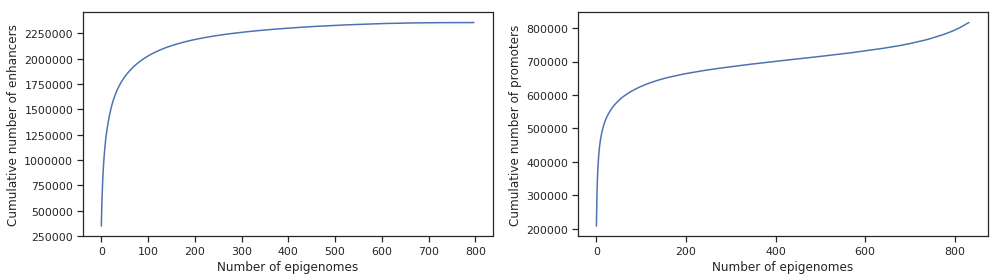

In [34]:
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
u, c = np.unique(me, return_counts=True)
plt.plot(np.cumsum(c[1:]))
plt.ylabel('Cumulative number of enhancers')
plt.xlabel('Number of epigenomes')


ax = plt.subplot(gs[1])
u, c = np.unique(mp, return_counts=True)
plt.plot(np.cumsum(c[1:]))
plt.ylabel('Cumulative number of promoters')
plt.xlabel('Number of epigenomes')
plt.tight_layout()

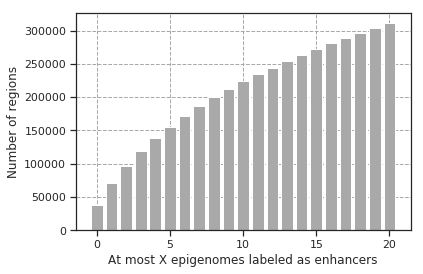

In [35]:
intp = [sum((df['ne'] <= i) & (df['np'] > 0)) for i in range(21)]
plt.bar(range(21), intp, color='darkgrey')
plt.xlabel("At most X epigenomes labeled as enhancers")
plt.ylabel("Number of regions")
plt.grid(True, linestyle='dashed', color='darkgrey')

### Defining promoters/enhancers/dyadic:
- **Roadmap approach:** We arbitrate on these regions by first clustering them (using the methods in the following section) with an expected cluster size of 10,000 regions, and then for each cluster calculating (a) the mean posterior probabilities for promoter and enhancer calls separately, and (b) the mean number of reference epigenomes in which regions were called promoter or enhancer. Clusters of regions for which the differences in mean posterior probabilities (a) is smaller than 0.05, or for which the absolute log 2 ratio of the number of epigenomes called as promoter or enhancer (b) is smaller than 0.05, are called true ‘dyadic’ regions, along with a small number of ‘ambiguous’ regions in state BivFlnk. Note that this particular clustering is only to arbitrate on these regions using group statistics instead of one-by-one;
- **Approach here** Based on statistics, choose elements as regions with 75%+ of that element. Ignores 122k regions -> dyadic

In [36]:
both = me + mp
ind = np.where(both > 0)[0]
fe = me[ind] / both[ind]
fe = np.round(fe, 2)
uf, cf = np.unique(fe, return_counts=True)
ccf = np.cumsum(cf)

# Get boxplot data:
bi = both[ind]
bpdata = []
for x in tqdm(uf):
    idx = np.where(fe == x)[0]
    bpdata.append(bi[idx])

100%|██████████| 101/101 [00:00<00:00, 454.06it/s]


In [37]:
# For broken plot:
def add_diaglines(ax, ax2, d=0.015):
    #d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

/home/cboix/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


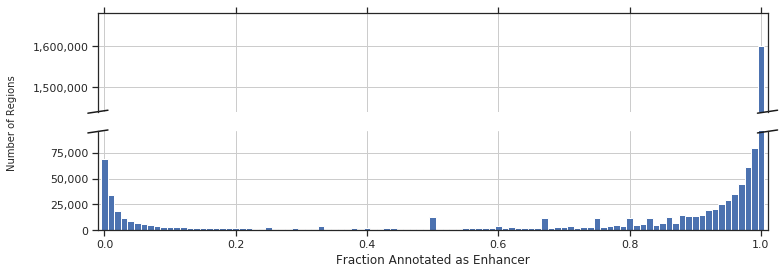

In [38]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

# Same data both:
ax.bar(list(uf), list(cf), width=0.01)
ax2.bar(list(uf), list(cf), width=0.01)

# zoom-in / limit the view to different portions of the data
t2 = np.sort(cf)[-2]
ax.set_ylim(np.max(cf) * .9, np.max(cf) * 1.05)  # outliers only
ax2.set_ylim(0, t2 * 1.2)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
# Format comma y-axis
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlim(-0.01, 1.01)

plt.xlabel('Fraction Annotated as Enhancer')
add_diaglines(ax, ax2)
f.text(0.02, 0.5, 'Number of Regions', va='center', rotation='vertical')

ax.grid(True)
ax2.grid(True)

/home/cboix/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Text(0.5, 0, 'Fraction Annotated as Enhancer')

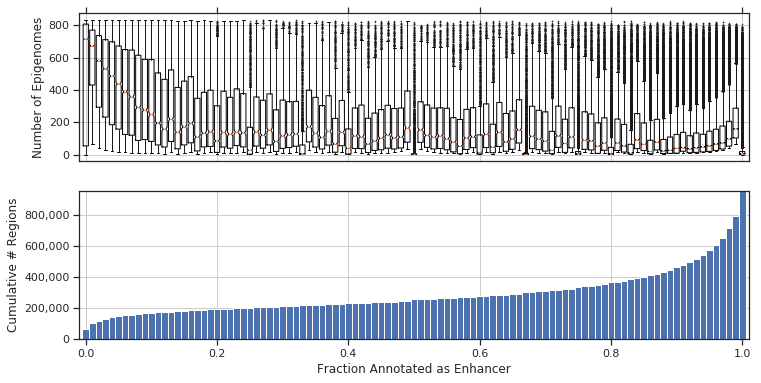

In [39]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
# Boxplots of specificity:
# pos = np.array(range(len(bpdata))) + 1
pos = uf
bp = ax.boxplot(bpdata, sym='k.', positions=pos, notch=1, widths=0.008)
plt.setp(bp['whiskers'], color='k', linestyle='-')
plt.setp(bp['fliers'], markersize=1.0)

# loc = mpl.ticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
# ax.xaxis.set_major_locator(loc)
ax.xaxis.set_ticks(np.arange(0, 1.05, 0.2))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

ax.set_ylabel('Number of Epigenomes')
ax.set_xlim(-0.01, 1.01)
ax.grid(True)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
#ax.set_xticks(np.arange(0, 1, 0.2))

# Cumulative regions:
ax2.bar(list(uf), list(ccf), width=0.01)
ax2.set_ylim(0, ccf[-1] - .9 * cf[-1])  # most of the data
ax2.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.grid(True)
ax2.set_ylabel('Cumulative # Regions')
ax2.set_xlabel('Fraction Annotated as Enhancer')

In [40]:
enhind = ind[fe >= 0.75]
promind = ind[fe <= 0.25]
print(len(enhind), 'Enhancer')
print(len(promind),'Promoter')
print(len(ind) - (len(promind) + len(enhind)), 'Mixed')

2069090 Enhancer
204103 Promoter
122356 Mixed


In [41]:
# Save enhancer indices:
eindpref = '/home/cboix' + os.environ['DBDIR'] + '/ENH_masterlist_indices'
pindpref = '/home/cboix' + os.environ['DBDIR'] + '/PROM_masterlist_indices'
AUX.save_pickle_gzip(eindpref + "_ind.cp.gz", enhind)
AUX.save_pickle_gzip(pindpref + "_ind.cp.gz", promind)

Text(0.5, 0, 'Distance (in masterlist rows) to next promoter')

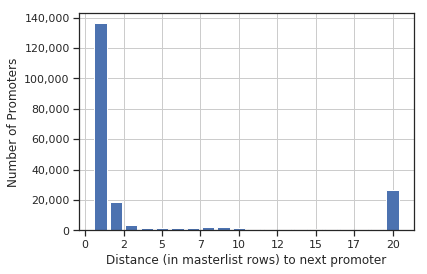

In [42]:
# How close are promoters?
plt.figure(figsize=(6,4))
dp = np.diff(promind)
top = 20
dp[dp > top] = top
ud, cd = np.unique(dp, return_counts=True)
ax = plt.gca()
ax.bar(list(ud), list(cd), width=.8)
ax.grid(True)
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x))))
ax.set_ylabel('Number of Promoters')
ax.set_xlabel('Distance (in masterlist rows) to next promoter')

Text(0.5, 0, 'Distance (in masterlist rows) to next enhancer')

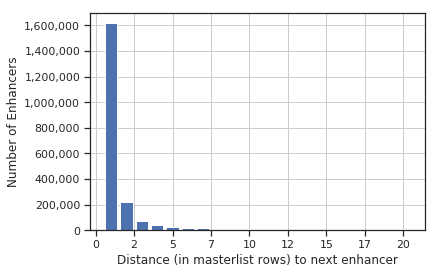

In [43]:
# How close are promoters?
plt.figure(figsize=(6,4))
dp = np.diff(enhind)
top = 20
dp[dp > top] = top
ud, cd = np.unique(dp, return_counts=True)
ax = plt.gca()
ax.bar(list(ud), list(cd), width=.8)
ax.grid(True)
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x))))
ax.set_ylabel('Number of Enhancers')
ax.set_xlabel('Distance (in masterlist rows) to next enhancer')

In [44]:
# Recalculate margins:
le = np.array(np.sum(ehx[enhind,:], axis=0))[0]
lp = np.array(np.sum(phx[promind, :], axis=0))[0]
me = np.array(np.sum(ehx[enhind, :], axis=1)).T[0]
mp = np.array(np.sum(phx[promind, :], axis=1)).T[0]

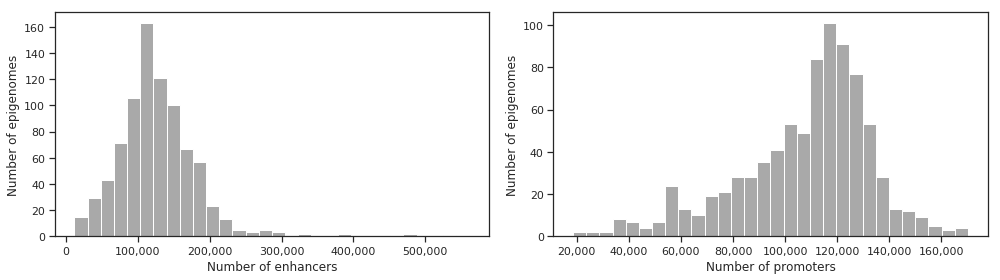

In [45]:
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
h = plt.hist(le, 30, color='darkgrey')
plt.ylabel('Number of epigenomes')
plt.xlabel('Number of enhancers')
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax = plt.subplot(gs[1])
h = plt.hist(lp, 30, color='darkgrey')
plt.xlabel('Number of promoters')
plt.ylabel('Number of epigenomes')
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

In [46]:
# TODO: Follow up on these by plotting their strengths and epigenomes: - WAY TOO many enhancers!? 
print(list(np.array(enam)[np.where(le > 375000)[0]]))

['BSS00003', 'BSS00471', 'BSS00482', 'BSS00501', 'BSS00551', 'BSS00554', 'BSS00719']


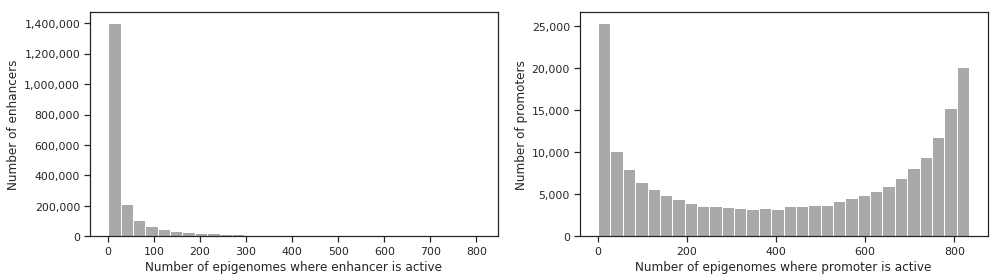

In [47]:
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
h = plt.hist(me[me > 0], 30, color='darkgrey')
plt.ylabel('Number of enhancers')
plt.xlabel('Number of epigenomes where enhancer is active')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax = plt.subplot(gs[1])
h = plt.hist(mp[mp > 0], 30, color='darkgrey')
plt.xlabel('Number of epigenomes where promoter is active')
plt.ylabel('Number of promoters')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

### Rarefaction curves:
1. By most contribution
2. Ordered by project

In [48]:
# Load the project idname mapping for saturation analysis:
pifile = os.environ['HOME'] + os.environ['DBDIR'] + "/project_id_table.tsv"
pidf = pd.read_csv(pifile, sep="\t")
print(np.unique(pidf['Project']))
print(len(pidf))
pidf.head()
enamproj = [pidf.iloc[np.where(pidf['id'] == n)[0][0]]['Project'] for n in enam]

['ENCODE' 'ENCODE 2012' 'GGR' 'Roadmap (Novel)' 'Roadmap 2015']
916


In [49]:
def get_rarefaction_curve(mat):
    erx = mat.copy().tocsc()
    ecurve = []
    eproj = []
    nenh = 1
    while nenh > 0:
        le = np.array(np.sum(erx, axis=0))[0]
        top = np.argmax(le)
        nenh = le[top]
        # print(nenh)
        ecurve.append(le[top])
        eproj.append(pidf['Project'][pidf['id'] == enam[top]].values[0])
        # Remove all enh associated with this one:
        ind = np.where(erx[:,top].toarray() == 0)[0]
        erx = erx[ind,:]
        # TODO remove that top index too?
    return(ecurve, eproj)

In [50]:
[ecurve, eproj] = get_rarefaction_curve(ehx[enhind,:])
# [ecurve, eproj] = get_rarefaction_curve(eX)
# print(ecurve,  eproj)

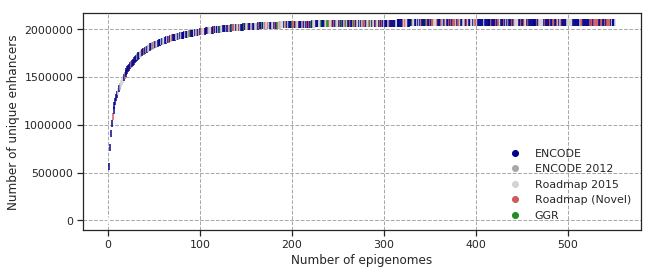

In [51]:
projcol = {'ENCODE': 'darkblue', 'ENCODE 2012': 'darkgrey',
           'Roadmap 2015':  'lightgrey', 'Roadmap (Novel)': 'indianred', 'GGR': 'forestgreen'}
epcol = ['white'] + [projcol[p] for p in eproj]

fig = plt.figure(figsize=(10, 4))
# plt.plot(np.cumsum([0] + ecurve), color='darkgrey', linestyle='dotted')
plt.scatter(range(len(ecurve) + 1), np.cumsum([0] + ecurve), c=epcol, s=50, marker='|')
plt.grid(True, linestyle='dashed', color='darkgrey')
plt.xlabel('Number of epigenomes')
plt.ylabel('Number of unique enhancers')
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in projcol.values()]
plt.legend(markers, projcol.keys(), numpoints=1, frameon=False, loc='best')

In [52]:
[ecurve, eproj] = get_rarefaction_curve(phx[promind,:])
# [ecurve, eproj] = get_rarefaction_curve(pX)
# print(ecurve,  eproj)

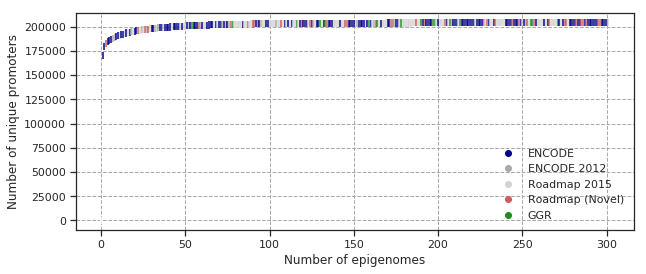

In [53]:
projcol = {'ENCODE': 'darkblue', 'ENCODE 2012': 'darkgrey',
           'Roadmap 2015':  'lightgrey', 'Roadmap (Novel)': 'indianred', 'GGR': 'forestgreen'}
epcol = ['white'] + [projcol[p] for p in eproj]

fig = plt.figure(figsize=(10, 4))
# plt.plot(np.cumsum([0] + ecurve), color='darkgrey', linestyle='dotted')
plt.scatter(range(len(ecurve) + 1), np.cumsum([0] + ecurve), c=epcol, s=50, marker='|')
plt.grid(True, linestyle='dashed', color='darkgrey')
plt.xlabel('Number of epigenomes')
plt.ylabel('Number of unique promoters')
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in projcol.values()]
plt.legend(markers, projcol.keys(), numpoints=1, frameon=False, loc='best')

#### 2. Perform rarefaction ordered by old - new datasets.

In [54]:
projord = ['ENCODE 2012', 'Roadmap 2015', 'Roadmap (Novel)', 'ENCODE', 'GGR']
ixdict = {}
for proj in projord:
    ixdict[proj]  = np.array(np.where(np.array(enamproj) == proj)[0])

def get_rarefaction_curve_ordered(mat, projord, ixdict=ixdict):
    erx = mat.copy().tocsc()
    ecurve = []
    eproj = []
    nenh = 1
    proj = projord[0]
    ix = np.array(ixdict[proj])
    print(proj)
    while nenh > 0:
        le = np.array(np.sum(erx, axis=0))[0]
        totproj = np.sum(le[ix])
        if totproj == 0:
            if len(projord) == 1:
                break
            projord = projord[1:]
            proj = projord[0]
            print(proj)
            ix = np.array(ixdict[proj])
        top = ix[np.argmax(le[ix])]
        nenh = le[top]
        # print(top, nenh)
        ecurve.append(le[top])
        eproj.append(pidf['Project'][pidf['id'] == enam[top]].values[0])
        # Remove all enh associated with this one:
        ind = np.where(erx[:,top].toarray() == 0)[0]
        erx = erx[ind,:]
    return(ecurve, eproj)

In [55]:
[ecurve, eproj] = get_rarefaction_curve_ordered(ehx[enhind,:], projord = projord)
# [ecurve, eproj] = get_rarefaction_curve_ordered(eX, projord = projord)
# print(ecurve,  eproj)

ENCODE 2012
Roadmap 2015
Roadmap (Novel)
ENCODE
GGR


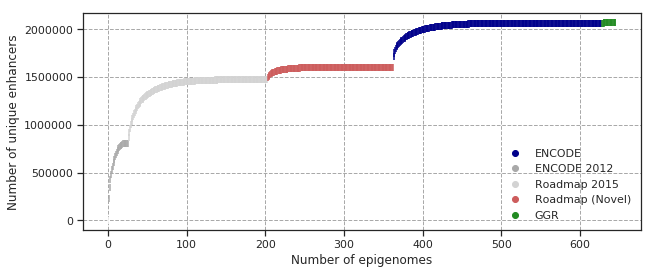

In [56]:
fig = plt.figure(figsize=(10, 4))
# plt.plot(np.cumsum([0] + ecurve), color='darkgrey', linestyle='dotted')
epcol = ['white'] + [projcol[p] for p in eproj]
plt.scatter(range(len(ecurve) + 1), np.cumsum([0] + ecurve), c=epcol, s=50, marker='|')
plt.grid(True, linestyle='dashed', color='darkgrey')
plt.xlabel('Number of epigenomes')
plt.ylabel('Number of unique enhancers')
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in projcol.values()]
plt.legend(markers, projcol.keys(), numpoints=1, frameon=False, loc='best')

In [57]:
[ecurve, eproj] = get_rarefaction_curve_ordered(phx[promind,:], projord = projord)
# [ecurve, eproj] = get_rarefaction_curve_ordered(pX, projord = projord)
# print(ecurve,  eproj)

ENCODE 2012
Roadmap 2015
Roadmap (Novel)
ENCODE
GGR


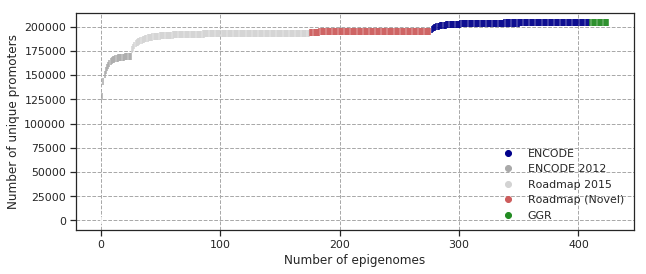

In [58]:
fig = plt.figure(figsize=(10, 4))
# plt.plot(np.cumsum([0] + ecurve), color='darkgrey', linestyle='dotted')
epcol = ['white'] + [projcol[p] for p in eproj]
plt.scatter(range(len(ecurve) + 1), np.cumsum([0] + ecurve), c=epcol, s=50, marker='|')
plt.grid(True, linestyle='dashed', color='darkgrey')
plt.xlabel('Number of epigenomes')
plt.ylabel('Number of unique promoters')
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in projcol.values()]
plt.legend(markers, projcol.keys(), numpoints=1, frameon=False, loc='best')

## Statistics relative to the strength of H3K27ac

In [59]:
# Merge valued matrices:
evx = eX.multiply(hXord)
pvx = pX.multiply(hXord)
# Get all + get not kept:
allsite = 1 * (eX + pX > 0)
kX = allsite.multiply(hXord)
notkX = hXord - kX
# TODO: Plot two hist comparisons - kept vs. not and prom vs. enh.

In [60]:
def histvals(mat, cutoff=50, nbin=50, title=None, ylab=False, xlab=False):
    vals = mat.data.copy()
    vals[vals > cutoff] = cutoff
    h = plt.hist(vals, nbin, color='darkgrey')
    if xlab:
        plt.xlabel('Average H3K27ac Signal')
    else:
        ax.set_xticklabels([])
    if ylab:
        plt.ylabel('Number of regions')
    plt.grid(True, linestyle='dashed', color='darkgrey')
    if title is not None:
        plt.title(title)

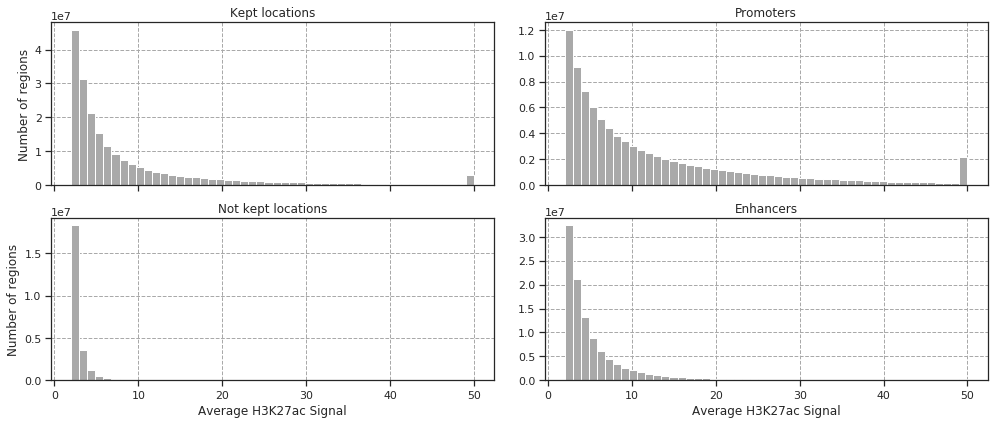

In [61]:
allind = np.concatenate([promind,enhind])

# Distribution of strengths:
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[0])
histvals(kX[allind,:], 50, title='Kept locations', ylab=True)
ax = plt.subplot(gs[1])
histvals(pvx[promind,:], 50, title='Promoters')
ax = plt.subplot(gs[2])
histvals(notkX[allind,:], 50, title='Not kept locations', xlab=True, ylab=True)
ax = plt.subplot(gs[3])
histvals(evx[enhind,:], 50, title='Enhancers', xlab=True)
plt.tight_layout()

In [62]:
# Strength against specificity:
spec = np.array(np.sum(evx[enhind,:] > 0, 1).T)[0]
sten = np.array(np.sum(evx[enhind,:], 1).T)[0]
avgst = sten / spec

Text(0, 0.5, 'Average H3K27ac signal in enhancers')

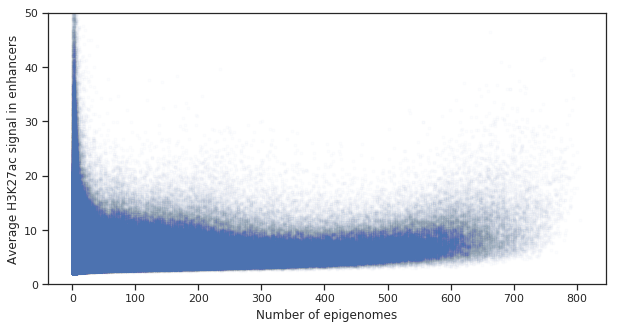

In [63]:
plt.figure(figsize=(10,5))
fig = plt.plot(spec, avgst, '.', alpha=0.01)
plt.ylim(0, 50)
plt.xlabel('Number of epigenomes')
plt.ylabel('Average H3K27ac signal in enhancers')

/home/cboix/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


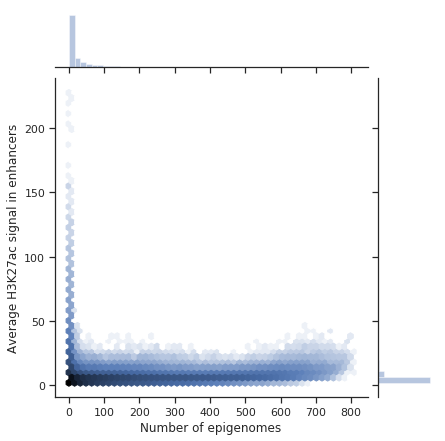

In [64]:
fig = sns.jointplot(spec, avgst, bins='log', kind='hex').set_axis_labels('Number of epigenomes', 'Average H3K27ac signal in enhancers')